# 20181030: Dog Race Prediction with a pre trained Resnet50 (TransferLearning)

Transfer Learning on a pre trained resnet50 from ImageNet.

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

from keras import models,layers,optimizers
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization, regularizers, Input
from keras.models import Model, Sequential 
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import cv2
from PIL import Image
import skimage
from skimage.io import imread, imsave
from skimage import transform

from bs4 import BeautifulSoup
import h5py
import xml.etree.ElementTree as ET
from google.colab import files
import scipy.io as sio
import tarfile
from six.moves.urllib.request import urlretrieve

Using TensorFlow backend.


In [0]:
#FULL RESTART
#!kill -9 -1

# Misc info

In [0]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/'

# Sub-features

In [0]:
#Create folders
def folder_create(path):
    os.makedirs(os.path.join(path), exist_ok=True)

In [0]:
#Dowload files
def downloadfile(filename, targetloc='.', url=url):
    dest_filename = os.path.join(targetloc, filename)
    filename, _ = urlretrieve(url + filename, dest_filename)
    print(dest_filename, 'created')
    return filename

In [0]:
#Extract files
def extract(filename, target, location = '.'):   
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(target)
    tar.close()
    print(filename, 'created')

# Dataset preparation

## Folder creation

In [0]:
# Folder creation
folder_create('lists')
folder_create('train')
folder_create('test')
folder_create('features')
folder_create('Annotation')

## Downloading

In [8]:
#Datadownloading
downloadfile('lists.tar')
downloadfile('annotation.tar')
downloadfile('images.tar')

./lists.tar created
./annotation.tar created
./images.tar created


'./images.tar'

## Data preparation

In [9]:
#File extraction
extract('lists.tar', target='lists/')
extract('annotation.tar', target='.')
extract('images.tar', target='.')

lists.tar created
annotation.tar created
images.tar created


In [10]:
!ls

Annotation	features  images.tar  lists.tar    test
annotation.tar	Images	  lists       sample_data  train


In [11]:
test_list = sio.loadmat('lists/test_list.mat')
train_list = sio.loadmat('lists/train_list.mat')
test_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [0]:
def spreadfiles(listmat, serie=None, annotation='Annotation', images='Images'):
    counter = 0
    for filepath in listmat['file_list']:
        counter +=1
        if counter % 1500 == 0:
            print(f'{counter} files done')
        cleanedfilepath = filepath[0][0]
        filename = os.path.split(cleanedfilepath)[-1].split('.')[0]
        foldername = os.path.split(cleanedfilepath)[0]
        details = {}
        with open(os.path.join(annotation, foldername, filename), 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f, 'html.parser')
            dog = soup.find('object')
            details['xmin'] = int(dog.xmin.string)
            details['xmax'] = int(dog.xmax.string)
            details['ymin'] = int(dog.ymin.string)
            details['ymax'] = int(dog.ymax.string)
        image_data = imread(os.path.join(images, foldername, f'{filename}.jpg'))
        new_image_data = image_data[details['ymin']:details['ymax'],details['xmin']:details['xmax'],:]
        newpath = os.path.join(serie, foldername)
        folder_create(newpath)
        try:
            imsave(os.path.join(newpath, f'{filename}.jpg'), new_image_data)
        except:
            print(f'problem with {filename} :-(')

In [13]:
%%time
spreadfiles(train_list, serie='train')

1500 files done
3000 files done
4500 files done
6000 files done
7500 files done
9000 files done
10500 files done
12000 files done
CPU times: user 3min 1s, sys: 7.79 s, total: 3min 9s
Wall time: 3min 10s


In [14]:
%%time
spreadfiles(test_list, serie='test')

1500 files done
3000 files done
4500 files done
6000 files done
7500 files done
CPU times: user 2min 9s, sys: 3.33 s, total: 2min 13s
Wall time: 2min 13s


# NN creation: Restnet50 without Top Layer  = "model0"

Features Extraction :  no layers training. For small dataset and similar to original dataset

In [15]:
model0 = ResNet50(weights="imagenet",
                  include_top=False, 
                  input_shape=(224, 224, 3),
                  pooling = 'avg'
                 )

94658560/94653016 [==============================] - 1s 0us/step


In [0]:
model0.compile(loss = "categorical_crossentropy", 
              optimizer = 'sgd',
              metrics=["accuracy"])

In [0]:
sauvegarde0 = model0.save('sauvegarde_0.h5')

In [0]:
files.download('sauvegarde_0.h5')

In [19]:
model0.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
for layer in model0.layers[:]:
    layer.trainable = False

In [21]:
# Check the trainable status of the individual layers
for layer in model0.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f159d4d0320> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f159ceb9e48> False
<keras.layers.convolutional.Conv2D object at 0x7f159ceb9668> False
<keras.layers.normalization.BatchNormalization object at 0x7f159ceb9c50> False
<keras.layers.core.Activation object at 0x7f159d4d0ef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f159d365b38> False
<keras.layers.convolutional.Conv2D object at 0x7f159d710048> False
<keras.layers.normalization.BatchNormalization object at 0x7f159cdaa198> False
<keras.layers.core.Activation object at 0x7f159d0927f0> False
<keras.layers.convolutional.Conv2D object at 0x7f159ceb9978> False
<keras.layers.normalization.BatchNormalization object at 0x7f159cdf3dd8> False
<keras.layers.core.Activation object at 0x7f159cf54588> False
<keras.layers.convolutional.Conv2D object at 0x7f159d28e9e8> False
<keras.layers.convolutional.Conv2D object at 0x7f159cfc75f8> False
<keras.layers.normalization.BatchNo

**- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - **

#Generator

Misc

In [0]:
train_data_dir = "train"
test_data_dir = "test"

img_width = 224
img_height = 224

batch_size = 16

nb_train_samples  = 12000
nb_validation_samples = 8580
epochs = 50

In [0]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    class_mode=None,
    batch_size=batch_size,
    shuffle=False)

Found 12000 images belonging to 120 classes.


In [0]:
bottleneck_features_train = model0.predict_generator(train_generator)

In [26]:
bottleneck_features_train

array([[0.74069285, 0.15516727, 0.        , ..., 2.9568105 , 0.33685625,
        0.21766798],
       [0.        , 0.        , 0.05354649, ..., 0.16494225, 0.15505166,
        0.6573303 ],
       [0.1052823 , 0.22859137, 0.10642652, ..., 0.1122757 , 0.6222735 ,
        0.05682056],
       ...,
       [0.        , 0.54635817, 0.19444072, ..., 0.21147327, 0.0812128 ,
        0.28938317],
       [0.42845434, 0.29389435, 0.03062267, ..., 0.00534179, 0.00669176,
        0.24404985],
       [0.06056613, 0.51164454, 0.32108283, ..., 0.24119358, 0.0865832 ,
        0.10316335]], dtype=float32)

In [0]:
train_labels = to_categorical(train_generator.classes , 
                              num_classes=120)

In [28]:
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [0]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [30]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode=None,
    batch_size=batch_size,
    shuffle=False)

Found 8580 images belonging to 120 classes.


In [0]:
bottleneck_features_test = model0.predict_generator(test_generator)

In [0]:
test_labels = to_categorical(test_generator.classes, 
                             num_classes=120)

### Labels saving

In [33]:
class_frame = pd.DataFrame.from_dict(test_generator.class_indices,
                                     orient='index')
class_frame = class_frame.reset_index()
class_frame['class'] = class_frame['index']
class_frame = pd.DataFrame(class_frame['class'])

class_frame.to_csv(path_or_buf='class_frame.csv')
files.download('class_frame.csv')

class_frame.head()

,class
0,n02085620-Chihuahua
1,n02085782-Japanese_spaniel
2,n02085936-Maltese_dog
3,n02086079-Pekinese
4,n02086240-Shih-Tzu


### Checkpoint

In [0]:
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

## Model Dense adding

In [35]:
bottleneck_features_train.shape[1:]

(2048,)

In [0]:
model = Sequential()

In [0]:
model.add(Dense(120, 
                activation='softmax', 
                name='pred', 
                input_shape = bottleneck_features_train.shape[1:]))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pred (Dense)                 (None, 120)               245880    
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = "categorical_crossentropy", 
              optimizer = 'sgd',
              metrics=["accuracy"])

'optimizers.SGD(lr=0.0024, # lr =  0.0016 --> 0.38,  lr =  0.002 --> 0.36, lr=0.0021 --> 0.60 
                                         decay=1e-6, 
                                         momentum=0.9), 

In [40]:
print(model.get_config())

[{'class_name': 'Dense', 'config': {'name': 'pred', 'trainable': True, 'batch_input_shape': (None, 2048), 'dtype': 'float32', 'units': 120, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]


# Model Fit

In [41]:
history = model.fit(bottleneck_features_train,train_labels,
                    epochs=15,
                    batch_size=batch_size,
                    validation_data=(bottleneck_features_test, test_labels),
                    callbacks = [early])

Train on 12000 samples, validate on 8580 samples
Epoch 1/15
12000/12000 [==============================] - 6s 470us/step - loss: 1.9502 - acc: 0.5636 - val_loss: 0.9762 - val_acc: 0.7562
Epoch 2/15
12000/12000 [==============================] - 5s 388us/step - loss: 0.7640 - acc: 0.8056 - val_loss: 0.7459 - val_acc: 0.7960
Epoch 3/15
12000/12000 [==============================] - 5s 388us/step - loss: 0.5759 - acc: 0.8509 - val_loss: 0.6854 - val_acc: 0.8017
Epoch 4/15
12000/12000 [==============================] - 5s 388us/step - loss: 0.4781 - acc: 0.8760 - val_loss: 0.6442 - val_acc: 0.8084
Epoch 5/15
12000/12000 [==============================] - 5s 389us/step - loss: 0.4142 - acc: 0.8958 - val_loss: 0.6054 - val_acc: 0.8199
Epoch 6/15
12000/12000 [==============================] - 5s 389us/step - loss: 0.3662 - acc: 0.9123 - val_loss: 0.5945 - val_acc: 0.8219
Epoch 7/15
12000/12000 [==============================] - 5s 389us/step - loss: 0.3276 - acc: 0.9226 - val_loss: 0.5905 - v

In [0]:
sauvegarde = model.save('sauvegarde_82.h5')

In [0]:
files.download('sauvegarde_82.h5')

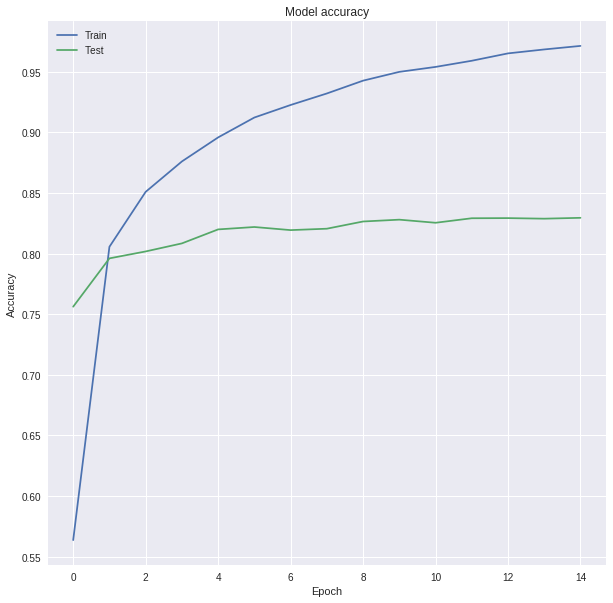

In [44]:
fig = plt.figure(figsize=(10,10))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


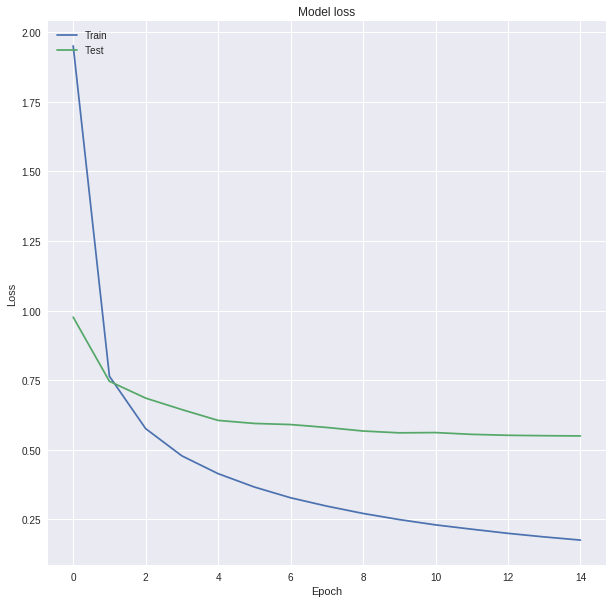

In [45]:
fig = plt.figure(figsize=(10,10))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Test with 1 Pic

### Load 2 Models from .h5

In [0]:
model0_test = models.load_model('sauvegarde_0.h5')

In [0]:
model_test = models.load_model('sauvegarde_82.h5')

### Pre processing

In [0]:
def reshape(img, dirs, name_tmp):
    name_tronc = name_tmp[:-4]
    name_annot = "Annotation/" + dirs +"/" + name_tronc  
    
    annot = ET.parse(name_annot)
    root = annot.getroot()

    xmin = root[5][4][0].text
    xmin = int(xmin)
    ymin = root[5][4][1].text
    ymin = int(ymin)
    xmax = root[5][4][2].text
    xmax = int(xmax)
    ymax = root[5][4][3].text
    ymax = int(ymax)

    # he crop rectangle, as a (left, upper, right, lower)-tuple.
    crop_rectangle = (xmin, ymin, xmax, ymax)

    cropped_im = img.crop(crop_rectangle)
    return cropped_im

In [49]:
name_file = 'test/n02085620-Chihuahua/n02085620_10131.jpg'
print("_File =", name_file)

_File = test/n02085620-Chihuahua/n02085620_10131.jpg


In [50]:
array = name_file.split("/")
array

['test', 'n02085620-Chihuahua', 'n02085620_10131.jpg']

In [51]:
i = 0
for word in array:
    if i == 0:
        test = word
        print(word)
    if i == 1:
        dirs = word
        print(word)
    if i == 2:
        name_tmp = word
        print(word)
    i = i + 1

test
n02085620-Chihuahua
n02085620_10131.jpg


In [52]:
name_file = 'test/n02085620-Chihuahua/n02085620_10131.jpg'
print("_File =", name_file)

array = name_file.split("/")
i = 0
for word in array:
    if i == 0:
        test = word
    if i == 1:
        dirs = word
    if i == 2:
        name_tmp = word
    i = i + 1

img = image.load_img(name_file, target_size=(224, 224))
img = np.array(img)
cv2.imwrite("image_tmp.jpg", img)
image_focus_tmp = Image.open("image_tmp.jpg")
img = reshape(image_focus_tmp, dirs, name_tmp)
img = img_to_array(img)
img = cv2.resize(img, dsize=(224, 224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  
img = preprocess_input(img)  

_File = test/n02085620-Chihuahua/n02085620_10131.jpg


In [53]:
type(img)

numpy.ndarray

In [54]:
img.shape

(1, 224, 224, 3)

###Prediction

In [0]:
features = model0_test.predict(img)

In [56]:
outcome = model_test.predict(features)
outcome.shape

(1, 120)

In [57]:
outcome

array([[3.34206849e-01, 2.71988858e-04, 3.69411823e-03, 3.90384719e-03,
        2.67426530e-03, 1.82106881e-03, 2.58522504e-03, 8.58615432e-03,
        2.13392064e-04, 2.35789944e-03, 6.41732514e-02, 1.39429513e-02,
        4.19901044e-04, 2.75072251e-02, 1.65266101e-03, 3.73793446e-04,
        1.78493524e-03, 1.77066133e-03, 3.28839496e-02, 1.54218613e-03,
        7.06152711e-03, 2.56560892e-02, 1.31511374e-03, 1.38357538e-03,
        6.61017373e-04, 2.44778418e-03, 6.90806005e-03, 5.59589686e-03,
        1.23727252e-03, 2.43308675e-03, 1.19135517e-03, 1.27717853e-03,
        7.22838100e-04, 4.54762077e-04, 1.76570285e-03, 9.64113642e-05,
        4.33309190e-02, 1.19443191e-03, 1.24535139e-03, 4.37937444e-04,
        5.55720180e-04, 1.18003727e-03, 6.21986052e-04, 3.66647169e-03,
        8.27442016e-03, 2.21906397e-02, 7.05255382e-03, 2.37789098e-03,
        4.38350486e-03, 2.81163957e-04, 8.02276132e-04, 5.81701752e-04,
        4.70674044e-04, 1.76424033e-03, 1.60259253e-03, 2.024981

In [58]:
outcome.argmax()

0

= Number of the predicted class, here = 0 = Chihuahua

In [59]:
class_frame.iloc[outcome.argmax()]

class    n02085620-Chihuahua
Name: 0, dtype: object